# <center>Semantic Data Processing and Representation</center>

# <center>Final Project</center>

## Sentence Classification for student essays:

**Problem Statement :**
    
        The objective of this task is to classify segments of student essays into one of 7 classes. These classes represent different types of statements typically found in essays. The classes and their corresponding numeric labels are as follows:

        1. Lead (0): The introductory statement or opening of the essay.
        2. Position (1): The main argument or stance taken in the essay.
        3. Evidence (2): Factual information or data supporting an argument.
        4. Claim (3): A statement that asserts something to be true, typically without providing evidence.
        5. Concluding Statement (4): The final summary or wrap-up of the essay.
        6. Counterclaim (5): A statement or position that opposes the initial claim or position.
        7. Rebuttal (6): A statement that refutes or contradicts a counterclaim.

        The task involves analyzing each segment of a students essay and assigning it to the most appropriate class based on its content and context within the essay.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import nltk
import pandas as pd
from tqdm.auto import tqdm
from datasets import Dataset
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
import spacy
import wordcloud
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import scipy.sparse as sp
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from nltk.stem.porter import PorterStemmer
import pickle

In [2]:
# Paths 
train_csv = r"C:\Semester 2\NLP\Final Project\Data\train.csv"
sub_csv = r"C:\Semester 2\NLP\Final Project\Data\sample_submission.csv"
train_path = r"C:\Semester 2\NLP\Final Project\Data\train"
test_path = r"C:\Semester 2\NLP\Final Project\Data\test"

In [3]:
# Read the CSV file
train = pd.read_csv(train_csv)

# Display the first few rows of the DataFrame
train.head()

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1622627660524,8,229,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1622627653021,230,312,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1622627671020,313,401,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1622627696365,402,758,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1622627759780,759,886,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...


## EXPLORATORY DATA ANALYSIS

In [4]:
article_id = "423A1CA112E2"

def get_text(article_id):
    article_file = f"{train_path}/{article_id}.txt"
    with open(article_file, "r") as file_pointer:
        text = file_pointer.read()
    return text

text = get_text(article_id)
print(text)

Phones







Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving. They are some really bad consequences when stuff happens when it comes to a phone. Some certain areas in the United States ban phones from class rooms just because of it.







When people have phones, they know about certain apps that they have .Apps like Facebook Twitter Instagram and Snapchat. So like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages. People always have different ways how to communicate with a phone. Phones have changed due to our generation.







Driving is one of the way how to get around. People always be on their phones while doing it. Which can cause serious Problems. That's why there's a thing that's called no texting while driving. That's a really important th

In [5]:
train_sample = train[train['id'] == article_id]
train_sample

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1622627660524,8,229,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1622627653021,230,312,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1622627671020,313,401,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1622627696365,402,758,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1622627759780,759,886,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...
5,423A1CA112E2,1622627780655,887,1150,That's why there's a thing that's called no te...,Evidence,Evidence 3,163 164 165 166 167 168 169 170 171 172 173 17...
6,423A1CA112E2,1622627811787,1151,1533,Sometimes on the news there is either an accid...,Evidence,Evidence 4,211 212 213 214 215 216 217 218 219 220 221 22...
7,423A1CA112E2,1622627585180,1534,1602,Phones are fine to use and it's also the best ...,Claim,Claim 2,282 283 284 285 286 287 288 289 290 291 292 29...
8,423A1CA112E2,1622627895668,1603,1890,If you go through a problem and you can't find...,Evidence,Evidence 5,297 298 299 300 301 302 303 304 305 306 307 30...
9,423A1CA112E2,1622627628524,1891,2027,The news always updated when people do somethi...,Concluding Statement,Concluding Statement 1,355 356 357 358 359 360 361 362 363 364 365 36...


### Understanding dataset more

**id** - ID code for essay response

**discourse_id** - ID code for discourse element

**discourse_start** - character position where discourse element begins in the essay response

**discourse_end** - character position where discourse element ends in the essay response

**discourse_text** - text of discourse element

**discourse_type** - classification of discourse element

**discourse_type_num** - enumerated class label of discourse element

**predictionstring** - the word indices of the training sample, as required for predictions

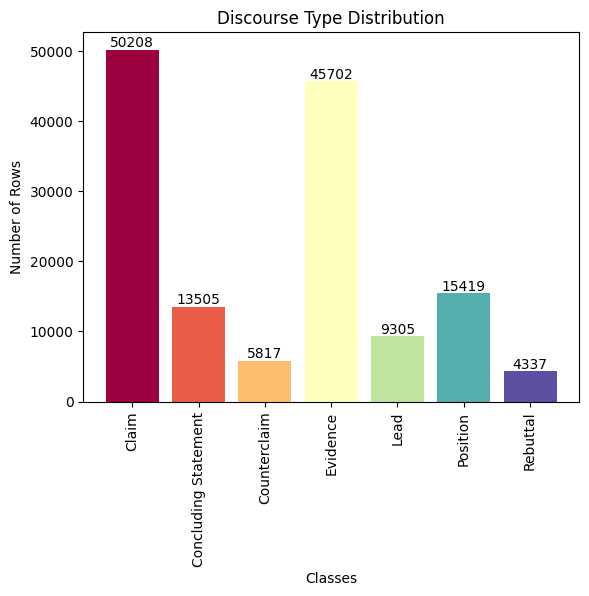

In [6]:
# Get unique classes and their counts
classes, counts = np.unique(train["discourse_type"], return_counts=True)

colors = plt.cm.Spectral(np.linspace(0, 1, len(classes)))
bars = plt.bar(classes, counts, color=colors)

plt.title('Discourse Type Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Rows')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.xticks(rotation=90)

plt.show()

In [8]:
# Files in train path: 
!dir /B /A-D "{train_path}" | find /c /v ""

15594


In [9]:
# Files in test path: 
!dir /B /A-D "{test_path}" | find /c /v ""

5


### Encoding Class labels:
    Certain portions are class-independent. To eliminate certain parts and prevent false positives, we are going to label them as No Class.

In [10]:
# There are 7 classes:
train['discourse_type'].value_counts(normalize=True)

discourse_type
Claim                   0.347959
Evidence                0.316731
Position                0.106859
Concluding Statement    0.093594
Lead                    0.064487
Counterclaim            0.040314
Rebuttal                0.030057
Name: proportion, dtype: float64

In [11]:
ID_to_Class = dict(enumerate(train['discourse_type'].unique().tolist() + ['No Class']))

Class_to_ID = {class_name: id for id, class_name in ID_to_Class.items()}

print("ID to Class Mapping:", ID_to_Class)
print("Class to ID Mapping:", Class_to_ID)


ID to Class Mapping: {0: 'Lead', 1: 'Position', 2: 'Evidence', 3: 'Claim', 4: 'Concluding Statement', 5: 'Counterclaim', 6: 'Rebuttal', 7: 'No Class'}



Class to ID Mapping: {'Lead': 0, 'Position': 1, 'Evidence': 2, 'Claim': 3, 'Concluding Statement': 4, 'Counterclaim': 5, 'Rebuttal': 6, 'No Class': 7}


In [12]:
# Retrieve a list of unique text IDs from the 'id' column
unique_text_ids = train['id'].unique().tolist()

selected_text_id = unique_text_ids[0]
retrieved_text = get_text(selected_text_id)
print(retrieved_text)


Phones







Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving. They are some really bad consequences when stuff happens when it comes to a phone. Some certain areas in the United States ban phones from class rooms just because of it.







When people have phones, they know about certain apps that they have .Apps like Facebook Twitter Instagram and Snapchat. So like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages. People always have different ways how to communicate with a phone. Phones have changed due to our generation.







Driving is one of the way how to get around. People always be on their phones while doing it. Which can cause serious Problems. That's why there's a thing that's called no texting while driving. That's a really important th

In [13]:
# Filter the training data to get the rows corresponding to the selected text ID
filtered_train_text = train[train['id'] == selected_text_id]

text_elements = filtered_train_text[['discourse_start', 'discourse_end', 'discourse_type']].to_records(index=False).tolist()

text_elements


[(8, 229, 'Lead'),
 (230, 312, 'Position'),
 (313, 401, 'Evidence'),
 (402, 758, 'Evidence'),
 (759, 886, 'Claim'),
 (887, 1150, 'Evidence'),
 (1151, 1533, 'Evidence'),
 (1534, 1602, 'Claim'),
 (1603, 1890, 'Evidence'),
 (1891, 2027, 'Concluding Statement')]

In [14]:
# Fill "No class" chunks: beginning and end
initial_idx = 0
final_idx = len(text)

new_elements = []
if text_elements[0][0] != initial_idx:
    starting_element = (0, text_elements[0][0]-1, 'No Class')
    new_elements.append(starting_element)

if text_elements[-1][1] != final_idx:
    closing_element = (text_elements[-1][1]+1, final_idx, 'No Class')
    new_elements.append(closing_element)

text_elements += new_elements
text_elements = sorted(text_elements, key=lambda x: x[0])

text_elements

[(0, 7, 'No Class'),
 (8, 229, 'Lead'),
 (230, 312, 'Position'),
 (313, 401, 'Evidence'),
 (402, 758, 'Evidence'),
 (759, 886, 'Claim'),
 (887, 1150, 'Evidence'),
 (1151, 1533, 'Evidence'),
 (1534, 1602, 'Claim'),
 (1603, 1890, 'Evidence'),
 (1891, 2027, 'Concluding Statement'),
 (2028, 2030, 'No Class')]

In [15]:
# Add "No class" elements between separated elements
new_elements_inbetween = []
for i in range(1, len(text_elements)-1):
    if text_elements[i][0] != text_elements[i-1][1] + 1 and text_elements[i][0] != text_elements[i-1][1]:
        new_element = (text_elements[i-1][1] + 1, text_elements[i][0] - 1, 'No Class')
        new_elements_inbetween.append(new_element)

text_elements += new_elements_inbetween
text_elements = sorted(text_elements, key=lambda x: x[0])
text_elements


[(0, 7, 'No Class'),
 (8, 229, 'Lead'),
 (230, 312, 'Position'),
 (313, 401, 'Evidence'),
 (402, 758, 'Evidence'),
 (759, 886, 'Claim'),
 (887, 1150, 'Evidence'),
 (1151, 1533, 'Evidence'),
 (1534, 1602, 'Claim'),
 (1603, 1890, 'Evidence'),
 (1891, 2027, 'Concluding Statement'),
 (2028, 2030, 'No Class')]

In [16]:
# Function to fill gaps with "No Class" elements
def fill_gaps(text_elements, retrieved_text):
    """Add 'No Class' elements to a list of text elements."""
    initial_idx = 0
    final_idx = len(retrieved_text)

    new_elements = []
    if text_elements and text_elements[0][0] != initial_idx:
        starting_element = (0, text_elements[0][0] - 1, 'No Class')
        new_elements.append(starting_element)

    if text_elements and text_elements[-1][1] != final_idx:
        closing_element = (text_elements[-1][1] + 1, final_idx, 'No Class')
        new_elements.append(closing_element)

    text_elements += new_elements
    text_elements = sorted(text_elements, key=lambda x: x[0])

    new_elements_inbetween = []
    for i in range(1, len(text_elements) - 1):
        if text_elements[i][0] != text_elements[i-1][1] + 1 and text_elements[i][0] != text_elements[i-1][1]:
            new_element = (text_elements[i-1][1] + 1, text_elements[i][0] - 1, 'No Class')
            new_elements_inbetween.append(new_element)

    text_elements += new_elements_inbetween
    text_elements = sorted(text_elements, key=lambda x: x[0])
    return text_elements

def get_elements(train_df, selected_text_id, do_fill_gaps=True, retrieved_text=None):
    """Get a list of (start, end, class) elements for a given text_id."""
    retrieved_text = get_text(selected_text_id) if retrieved_text is None else retrieved_text
    filtered_train_text = train_df[train_df['id'] == selected_text_id]
    text_elements = filtered_train_text[['discourse_start', 'discourse_end', 'discourse_type']].to_records(index=False).tolist()
    if do_fill_gaps:
        text_elements = fill_gaps(text_elements, retrieved_text)
    return text_elements


In [17]:
def get_x_samples(train_df, selected_text_id, do_fill_gaps=True):
    """Create a dataframe of the sentences of the selected_text_id, with columns text, label."""
    retrieved_text = get_text(selected_text_id)
    text_elements = get_elements(train_df, selected_text_id, do_fill_gaps, retrieved_text)
    sentences = []
    for start, end, class_ in text_elements:
        element_sentences = nltk.sent_tokenize(retrieved_text[start:end])
        sentences += [(sentence, class_) for sentence in element_sentences]
    sentences_df = pd.DataFrame(sentences, columns=['text', 'label'])
    sentences_df['label'] = sentences_df['label'].map(Class_to_ID)
    return sentences_df

sample_df = get_x_samples(train, unique_text_ids[1])
sample_df

,text,label
0,Phones & Driving,7
1,Drivers should not be able to use phones while...,1
2,Drivers who used their phone while operating a...,3
3,According to an article by the Edgar Snyder Fi...,2
4,"According to the same article, 35% know the ri...",2
5,This shows that its beyond dangerous and irres...,2
6,Drivers should be able to concentrate without ...,2
7,"According to another article, ""Distracted Driv...",2
8,The article states that teen get too distracte...,2
9,Accidents that can be easily avoided by focusi...,2


#### Build the full dataframe for sentence classification

In [18]:
# # This will takes a more time because our dataset is more.

# x = []
# for selected_text_id in tqdm(unique_text_ids):
#     x.append(get_x_samples(train, selected_text_id))

# combined_sentence_data = pd.concat(x)
# combined_sentence_data = combined_sentence_data[combined_sentence_data.text.str.split().str.len() >= 3]

# #Save the results to a CSV file
# combined_sentence_data.to_csv('combined_sentence_data.csv', index=False)

**Final combined_sentence_data.csv is attached in the folder.**

# <center>Model Building for classification </center>

**The model training was conducted on Kaggle's platform, utilizing their GPU resources. This was necessary due to the extensive data volume, which required GPU acceleration for efficient processing.**


In [2]:
combined_sentence_data = pd.read_csv('/kaggle/input/combined-sentence-data/combined_sentence_data.csv')
combined_sentence_data

,text,label
0,Modern humans today are always on their phone.,0
1,They are always on their phone more than 5 hou...,0
2,They even do it while driving.,0
3,They are some really bad consequences when stu...,1
4,Some certain areas in the United States ban ph...,2
...,...,...
348048,it is better to seek multiple opinions instead...,1
348049,The impact of asking people to help you make a...,2
348050,there are many other reasons one might want to...,4
348051,The key thing that all of these examples have ...,4


In [3]:
# using 50% of the data for modeling
combined_sentence_data = combined_sentence_data.sample(frac=0.5, random_state=42)

In [4]:
combined_sentence_data.shape

(174026, 2)

## Random Forest Model

In [5]:
#TFIDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

X = tfidf_vectorizer.fit_transform(combined_sentence_data['text'])
y = combined_sentence_data['label']
print(X.shape)
print(y.shape)

(174026, 5000)
(174026,)


In [6]:
# Split the dataset (80% train, 20% test)
split_point = int(len(combined_sentence_data) * 0.8)
X_train = X[:split_point]
X_test = X[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(139220, 5000)
(139220,)
(34806, 5000)
(34806,)


In [7]:
# Train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [8]:
# Predictions and Evaluation
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.09      0.15      2856
           1       0.56      0.34      0.42      1765
           2       0.55      0.96      0.70     17064
           3       0.50      0.16      0.25      5476
           4       0.53      0.09      0.15      4262
           5       0.58      0.06      0.11       726
           6       0.45      0.02      0.04       652
           7       0.72      0.28      0.40      2005

    accuracy                           0.55     34806
   macro avg       0.56      0.25      0.28     34806
weighted avg       0.55      0.55      0.46     34806

Accuracy: 0.550020111475033


# Stemming for Random Forest Model

In [10]:
nltk.download('punkt')

# Initialize the Porter Stemmer
stemmer = PorterStemmer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in nltk.word_tokenize(doc))

# TFIDF Vectorization with stemming
tfidf_vectorizer = TfidfVectorizer(tokenizer=stemmed_words, max_features=5000)

X = tfidf_vectorizer.fit_transform(combined_sentence_data['text'])
y = combined_sentence_data['label']

print(X.shape)
print(y.shape)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
(174026, 5000)
(174026,)


In [11]:
split_point = int(len(combined_sentence_data) * 0.8)
X_train = X[:split_point]
X_test = X[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(139220, 5000)
(139220,)
(34806, 5000)
(34806,)


In [12]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
# Predictions and Evaluation
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.11      0.18      2856
           1       0.60      0.34      0.44      1765
           2       0.56      0.97      0.71     17064
           3       0.59      0.26      0.37      5476
           4       0.56      0.09      0.15      4262
           5       0.63      0.07      0.12       726
           6       0.47      0.01      0.02       652
           7       0.80      0.31      0.44      2005

    accuracy                           0.57     34806
   macro avg       0.61      0.27      0.30     34806
weighted avg       0.59      0.57      0.49     34806

Accuracy: 0.5729184623340803


# Using Glove embeddings on RF using Glove.6B.100d

In [14]:
nltk.download('punkt')

combined_sentence_data['tokenized_text'] = combined_sentence_data['text'].apply(word_tokenize)

word2vec_model = Word2Vec(combined_sentence_data['tokenized_text'], vector_size=100, window=5, min_count=1, workers=4)

def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in word2vec_model.wv.index_to_key]
    return np.mean(word2vec_model.wv[doc], axis=0)

X = np.vstack(combined_sentence_data['tokenized_text'].apply(lambda x: document_vector(word2vec_model, x)))

def load_glove_model(glove_file):
    with open(glove_file, 'r', encoding='utf8') as f:
        model = {}
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(val) for val in split_line[1:]])
            model[word] = embedding
        return model

glove_model = load_glove_model("/kaggle/input/glove6b/glove.6B.100d.txt")

def document_vector_glove(glove_model, doc):
    doc = [word for word in doc if word in glove_model]

    if not doc:
        return np.zeros(100)
    else:
        return np.mean([glove_model[word] for word in doc], axis=0)

X = np.vstack(combined_sentence_data['tokenized_text'].apply(lambda x: document_vector_glove(glove_model, x)))
y = combined_sentence_data['label']

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
split_point = int(len(combined_sentence_data) * 0.8)
X_train = X[:split_point]
X_test = X[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]


In [16]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [17]:
# Predictions and Evaluation
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.05      0.08      2856
           1       0.63      0.17      0.27      1765
           2       0.52      0.98      0.68     17064
           3       0.44      0.10      0.16      5476
           4       0.28      0.02      0.03      4262
           5       0.43      0.00      0.01       726
           6       0.50      0.00      0.01       652
           7       0.82      0.23      0.36      2005

    accuracy                           0.52     34806
   macro avg       0.53      0.19      0.20     34806
weighted avg       0.50      0.52      0.40     34806

Accuracy: 0.5227259667873355


# Doc2Vec for Random Forest Model

In [18]:
nltk.download('punkt')

# Tokenizing text data
combined_sentence_data['tokenized_text'] = combined_sentence_data['text'].apply(word_tokenize)

tagged_data = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(combined_sentence_data['tokenized_text'])]

model = Doc2Vec(tagged_data, vector_size=100, window=2, min_count=1, workers=4, epochs=40)

def vectorize_doc(model, doc):
    return model.infer_vector(doc)

X = np.array([vectorize_doc(model, doc) for doc in combined_sentence_data['tokenized_text']])
y = combined_sentence_data['label']

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
split_point = int(len(combined_sentence_data) * 0.8)
X_train = X[:split_point]
X_test = X[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(139220, 100)
(139220,)
(34806, 100)
(34806,)


In [20]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [21]:
# Predictions and Evaluation
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.01      0.03      2856
           1       0.71      0.09      0.16      1765
           2       0.50      0.99      0.67     17064
           3       0.54      0.05      0.08      5476
           4       0.38      0.00      0.01      4262
           5       0.00      0.00      0.00       726
           6       1.00      0.00      0.00       652
           7       0.77      0.15      0.26      2005

    accuracy                           0.51     34806
   macro avg       0.57      0.16      0.15     34806
weighted avg       0.53      0.51      0.37     34806

Accuracy: 0.509366201229673


## Bert from Hugging Face

In [22]:
Bert = "/kaggle/input/bert-base-cased"
Labels = 8
Epochs = 5

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(Bert)

# Silence some annoying logging of HF
transformers.logging.set_verbosity_warning() 

split = int(len(combined_sentence_data) * 0.8)
df_train = Dataset.from_pandas(combined_sentence_data.iloc[:split])
df_val = Dataset.from_pandas(combined_sentence_data.iloc[split:])

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=326)

# Tokenize dataset
df_train_tokenized = df_train.map(preprocess_function, batched=True)
df_val_tokenized = df_val.map(preprocess_function, batched=True)

  0%|          | 0/140 [00:00<?, ?ba/s]

  0%|          | 0/35 [00:00<?, ?ba/s]

In [23]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(Bert, num_labels=Labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
Arguments = TrainingArguments(output_dir='feeeback-classifier',learning_rate=2e-5, per_device_train_batch_size=32,per_device_eval_batch_size=32,
    num_train_epochs=Epochs,weight_decay=0.01,report_to="none",evaluation_strategy="epoch",save_strategy="epoch",)
training = Trainer(model=model,args=Arguments,train_dataset=df_train_tokenized,
                  eval_dataset=df_val_tokenized,tokenizer=tokenizer )

In [25]:
df_train_tokenized

Dataset({
    features: ['text', 'label', 'tokenized_text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 139220
})

In [26]:
df_val_tokenized

Dataset({
    features: ['text', 'label', 'tokenized_text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 34806
})

In [27]:
training.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,1.061600,1.056385
2,0.972000,1.049861
3,0.868000,1.069468
4,0.771400,1.123274
5,0.694800,1.167948


TrainOutput(global_step=10880, training_loss=0.8927573849173153, metrics={'train_runtime': 22377.9415, 'train_samples_per_second': 31.107, 'train_steps_per_second': 0.486, 'total_flos': 1.166223436924704e+17, 'train_loss': 0.8927573849173153, 'epoch': 5.0})

In [28]:
training.save_model("Bert_trained_model")

###  Make predictions

In [29]:
predictions = training.predict(df_val_tokenized)

preds = np.argmax(predictions.predictions, axis=1)

accuracy = accuracy_score(df_val_tokenized['label'], preds)
print("Accuracy on the validation set:", accuracy)


Accuracy on the validation set: 0.6327644658966844


##### Streamlit application has been developed to use the BERT Model for making predictions on student essay sentences.

#### References:

1. [Bert-Base-Cased Model](https://huggingface.co/bert-base-cased)
2. [Glove Embeddings](https://nlp.stanford.edu/projects/glove/)
3. [Hugging Face Transfomers](https://huggingface.co/docs/transformers/training)

# <center>THE END</center>